In [16]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv
from PIL import Image, ImageOps

In [17]:
data_path = '../raw_data/age_gender.csv'

In [18]:
data = pd.read_csv(data_path)

In [19]:
data.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [20]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [21]:
def pixel_mirroring(pixel):
    array=np.uint8(pixel.reshape((48,48)))
    img=Image.fromarray(array, 'L')
    img=ImageOps.mirror(img)
    img=img.getdata()
    pixel_mirror=np.array(img, dtype=np.float32)
    return pixel_mirror

# Modeling

In [22]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [23]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = to_categorical(data['ethnicity'],num_classes=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
np.array(data['pixels'].tolist()).reshape((-1, 48, 48,1)).shape

(23705, 48, 48, 1)

In [25]:
X_train.shape

(16593, 48, 48, 1)

In [26]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=1)
data_train, data_validation, y_train, y_validation = train_test_split(data_train, y_train, test_size=0.2, random_state=1)

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

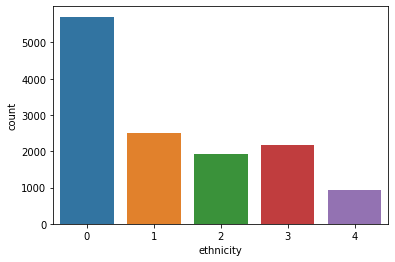

In [27]:
sns.countplot(data=data_train,x='ethnicity')

In [28]:
whites=data_train[data_train['ethnicity']==0]
blacks=data_train[data_train['ethnicity']==1]
asians=data_train[data_train['ethnicity']==2]
indians=data_train[data_train['ethnicity']==3]
hispanics=data_train[data_train['ethnicity']==4]
hispanics_mirrored=hispanics.copy()
hispanics_mirrored['pixels']=hispanics_mirrored['pixels'].apply(pixel_mirroring)

In [29]:
data_train['ethnicity'] = data_train['ethnicity'].replace(4,3)

In [30]:
data_train[data_train['ethnicity']==4]['ethnicity']

Series([], Name: ethnicity, dtype: int64)

In [31]:
whites_under20=whites[whites['age']<=20]
whites_over20=whites[whites['age']>20]
whites_under20.shape, whites_over20.shape

((1177, 5), (4531, 5))

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

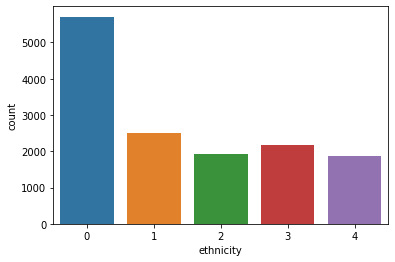

In [32]:
data_train=pd.concat([whites, blacks, asians, indians, hispanics, hispanics_mirrored])
sns.countplot(data=data_train,x='ethnicity')

In [33]:
data_train.shape, X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

NameError: name 'X_validation' is not defined

In [34]:
y_train= to_categorical(data_train['ethnicity'],num_classes=5)
y_validation= to_categorical(data_validation['ethnicity'],num_classes=5)
y_test= to_categorical(data_test['ethnicity'],num_classes=5)

X_train= np.reshape(data_train['pixels'].tolist(), (-1, 48, 48,1))
X_validation= np.reshape(data_validation['pixels'].tolist(), (-1, 48, 48,1))
X_test= np.reshape(data_test['pixels'].tolist(), (-1, 48, 48,1))

In [35]:
X_train.shape, y_train.shape

((14211, 48, 48, 1), (14211, 5))

In [36]:
X_test[0]

array([[[ 34.],
        [ 42.],
        [ 45.],
        ...,
        [ 60.],
        [ 27.],
        [ 25.]],

       [[ 30.],
        [ 47.],
        [ 46.],
        ...,
        [ 78.],
        [ 26.],
        [ 17.]],

       [[ 29.],
        [ 51.],
        [ 34.],
        ...,
        [110.],
        [ 50.],
        [ 21.]],

       ...,

       [[ 37.],
        [ 24.],
        [ 25.],
        ...,
        [139.],
        [123.],
        [116.]],

       [[ 31.],
        [ 29.],
        [ 32.],
        ...,
        [165.],
        [113.],
        [116.]],

       [[ 28.],
        [ 32.],
        [ 31.],
        ...,
        [210.],
        [128.],
        [117.]]], dtype=float32)

## Test 1

In [38]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(5, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall'])
    
    return model

In [ ]:
model = initialize_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train,y_train,
                    validation_data=(X_validation,y_validation),
                    epochs=50, 
                    batch_size=32,
                    callbacks=[es])

2022-06-01 16:12:13.958375: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-01 16:12:13.958558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-RM2V0FMT): /proc/driver/nvidia/version does not exist
2022-06-01 16:12:13.960210: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 16:12:14.205568: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 130968576 exceeds 10% of free system memory.


Epoch 1/50
445/445 [==============================] - 71s 156ms/step - loss: 1.6544 - accuracy: 0.4073 - precision: 0.5156 - recall: 0.0754 - val_loss: 1.2809 - val_accuracy: 0.5170 - val_precision: 0.7410 - val_recall: 0.1672
Epoch 2/50
445/445 [==============================] - 68s 152ms/step - loss: 1.2503 - accuracy: 0.5183 - precision: 0.6742 - recall: 0.2911 - val_loss: 1.1528 - val_accuracy: 0.5562 - val_precision: 0.7412 - val_recall: 0.3287
Epoch 3/50
445/445 [==============================] - 69s 155ms/step - loss: 1.1016 - accuracy: 0.5750 - precision: 0.7278 - recall: 0.4075 - val_loss: 0.9809 - val_accuracy: 0.6638 - val_precision: 0.8244 - val_recall: 0.4200
Epoch 4/50
445/445 [==============================] - 66s 149ms/step - loss: 1.0466 - accuracy: 0.5997 - precision: 0.7471 - recall: 0.4412 - val_loss: 0.9404 - val_accuracy: 0.6619 - val_precision: 0.8152 - val_recall: 0.4785
Epoch 5/50
445/445 [==============================] - 66s 149ms/step - loss: 1.0038 - accura

In [111]:
#plot Accuracy

def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

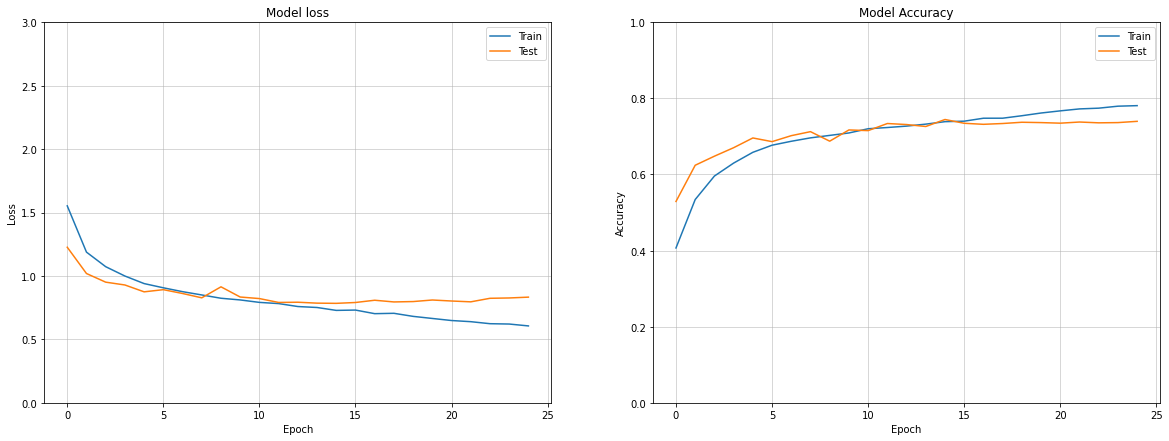

In [20]:
plot_loss_accuracy(history, title=None)

In [112]:
results_test = model.evaluate(X_test, y_test, verbose = 0)

In [113]:
results_test

[0.8164066672325134, 0.7414229512214661]

In [114]:
predictions=model.predict(X_test)

In [144]:
y_test_1d=[np.argmax(y) for y in y_test]
predictions_1d=[np.argmax(y) for y in predictions]

In [151]:
dict={'y_test':y_test_1d,'predictions':predictions_1d}
df=pd.DataFrame.from_dict(dict)
df['results']=(df['y_test']==df['predictions'])
df

,y_test,predictions,results
0,2,2,True
1,0,0,True
2,1,1,True
3,3,3,True
4,0,0,True
...,...,...,...
7107,0,0,True
7108,1,1,True
7109,3,3,True
7110,2,2,True


In [153]:
df.groupby(['y_test']).mean()['results']

y_test
0    0.901974
1    0.789165
2    0.734177
3    0.614557
4    0.003839
Name: results, dtype: float64

In [37]:
prediction=model.predict(X_test[0])

NameError: name 'model' is not defined

## Test 2

In [23]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32,(2,2),activation='relu'))
    
    model.add(layers.Conv2D(32,(2,2),activation='relu'))

    model.add(layers.Conv2D(16,(2,2),activation='relu'))
    model.add(layers.Dropout(0.2)) 

    model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(5, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [24]:
model2 = initialize_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history2 = model2.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=50, 
                    batch_size=32,
                    callbacks=[es])

Epoch 1/50


2022-05-31 14:39:48.527824: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122333184 exceeds 10% of free system memory.


415/415 [==============================] - 61s 145ms/step - loss: 1.3679 - accuracy: 0.4413 - val_loss: 1.1260 - val_accuracy: 0.5806
Epoch 2/50
415/415 [==============================] - 60s 145ms/step - loss: 1.1227 - accuracy: 0.5715 - val_loss: 0.9760 - val_accuracy: 0.6659
Epoch 3/50
415/415 [==============================] - 58s 139ms/step - loss: 0.9884 - accuracy: 0.6332 - val_loss: 0.9194 - val_accuracy: 0.6939
Epoch 4/50
415/415 [==============================] - 57s 137ms/step - loss: 0.9427 - accuracy: 0.6586 - val_loss: 0.8989 - val_accuracy: 0.6909
Epoch 5/50
415/415 [==============================] - 57s 137ms/step - loss: 0.9070 - accuracy: 0.6718 - val_loss: 0.8603 - val_accuracy: 0.6981
Epoch 6/50
415/415 [==============================] - 57s 137ms/step - loss: 0.8686 - accuracy: 0.6840 - val_loss: 0.8464 - val_accuracy: 0.7096
Epoch 7/50
415/415 [==============================] - 56s 134ms/step - loss: 0.8389 - accuracy: 0.7020 - val_loss: 0.8900 - val_accuracy: 0.6

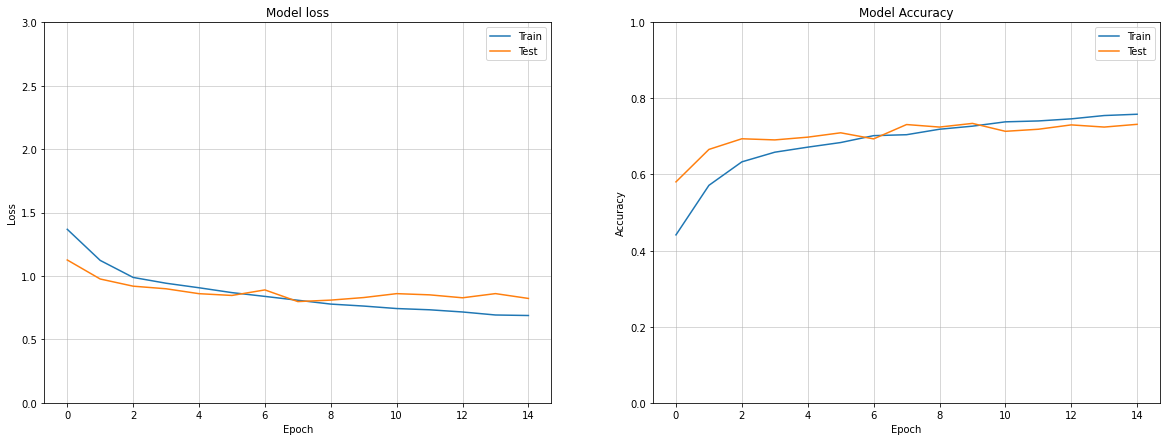

In [25]:
plot_loss_accuracy(history2, title=None)

In [26]:
model2.evaluate(X_test, y_test, verbose = 0)

## Test 3

In [40]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(48,48,1), padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3),activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2,2))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32,(2,2),activation='relu'))
    model.add(layers.Conv2D(32,(2,2),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
              
    model.add(layers.Conv2D(16,(2,2),activation='relu'))

    model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(5, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [41]:
model3 = initialize_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 1, 
                   verbose = 1, 
                   restore_best_weights = True)

history3 = model3.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=50, 
                    batch_size=32,
                    callbacks=[es])

Epoch 1/50
415/415 [==============================] - 355s 854ms/step - loss: 1.5678 - accuracy: 0.4152 - val_loss: 1.5047 - val_accuracy: 0.4284
Epoch 2/50
415/415 [==============================] - 363s 876ms/step - loss: 1.4690 - accuracy: 0.4338 - val_loss: 1.4591 - val_accuracy: 0.4327
Epoch 3/50
415/415 [==============================] - 365s 880ms/step - loss: 1.3378 - accuracy: 0.4898 - val_loss: 1.1812 - val_accuracy: 0.5553
Epoch 4/50
415/415 [==============================] - 368s 888ms/step - loss: 1.0467 - accuracy: 0.6196 - val_loss: 1.0305 - val_accuracy: 0.6342
Epoch 5/50
415/415 [==============================] - 362s 873ms/step - loss: 0.9415 - accuracy: 0.6624 - val_loss: 0.9460 - val_accuracy: 0.6574
Epoch 6/50
415/415 [==============================] - 358s 863ms/step - loss: 0.8740 - accuracy: 0.6897 - val_loss: 0.9076 - val_accuracy: 0.6770
Epoch 7/50
415/415 [==============================] - 356s 858ms/step - loss: 0.8374 - accuracy: 0.7045 - val_loss: 0.8538 -

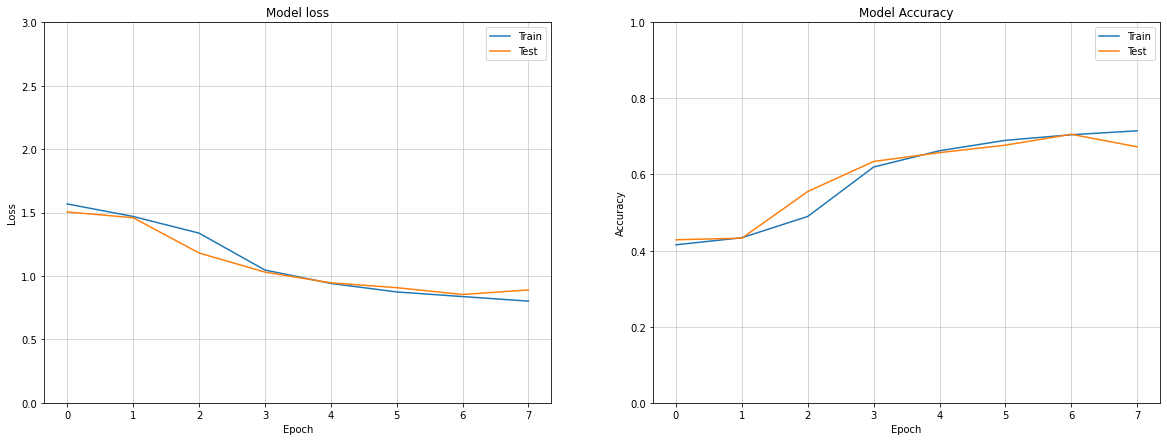

In [43]:
plot_loss_accuracy(history3, title=None)

In [44]:
model3.evaluate(X_test, y_test, verbose = 0)

[0.8403927683830261, 0.7017716765403748]

## Test 4

In [126]:
def initialize_model():
    
    model = Sequential()

    model.add(layers.Conv2D(64,(3,3),activation='relu',padding = "same",input_shape=(48,48,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(32,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(5, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [129]:
model4 = initialize_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history4 = model4.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=50, 
                    batch_size=32,
                    callbacks=[es])

Epoch 1/50
415/415 [==============================] - 23s 54ms/step - loss: 1.4242 - accuracy: 0.5431 - val_loss: 1.0908 - val_accuracy: 0.5957
Epoch 2/50
415/415 [==============================] - 22s 53ms/step - loss: 1.0028 - accuracy: 0.6338 - val_loss: 1.0137 - val_accuracy: 0.6255
Epoch 3/50
415/415 [==============================] - 22s 54ms/step - loss: 0.9334 - accuracy: 0.6602 - val_loss: 0.9566 - val_accuracy: 0.6547
Epoch 4/50
415/415 [==============================] - 23s 55ms/step - loss: 0.8944 - accuracy: 0.6815 - val_loss: 0.9193 - val_accuracy: 0.6710
Epoch 5/50
415/415 [==============================] - 22s 53ms/step - loss: 0.8688 - accuracy: 0.6901 - val_loss: 0.9232 - val_accuracy: 0.6674
Epoch 6/50
415/415 [==============================] - 22s 54ms/step - loss: 0.8451 - accuracy: 0.6951 - val_loss: 0.9001 - val_accuracy: 0.6794
Epoch 7/50
415/415 [==============================] - 23s 55ms/step - loss: 0.8120 - accuracy: 0.7105 - val_loss: 0.9241 - val_accuracy:

In [ ]:
plot_loss_accuracy(history4, title=None)

In [ ]:
model4.evaluate(X_test, y_test, verbose = 0)

## Test 5

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

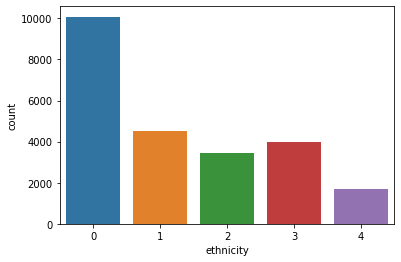

In [203]:
sns.countplot(data=data,x='ethnicity')

In [204]:
whites=data[data['ethnicity']==0]
blacks=data[data['ethnicity']==1]
asians=data[data['ethnicity']==2]
indians=data[data['ethnicity']==3]
hispanics=data[data['ethnicity']==4]

In [205]:
hispanics['ethnicity']=3

/tmp/ipykernel_32545/390702453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hispanics['ethnicity']=3


<AxesSubplot:xlabel='ethnicity', ylabel='count'>

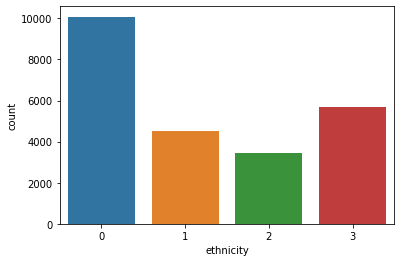

In [206]:
data_new=pd.concat([whites, blacks, asians, indians, hispanics])
sns.countplot(data=data_new,x='ethnicity')

In [207]:
X = data_new['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = to_categorical(data_new['ethnicity'],num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [208]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.1))          

    model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(4, activation='softmax'))
    
    initial_learning_rate = 0.001 # start with default Adam value

    lr_schedule = ExponentialDecay(
        # Every 4000 iterations, multiply the learning rate by 0.7
        initial_learning_rate, decay_steps = 4000, decay_rate = 0.7,
    )
    
    opt = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall'])
    
    return model

In [209]:
model5 = initialize_model()

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history5 = model5.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=200, 
                    batch_size=32,
                    callbacks=[es])

Epoch 1/200
415/415 [==============================] - 59s 139ms/step - loss: 1.3227 - accuracy: 0.4772 - precision: 0.5986 - recall: 0.2532 - val_loss: 0.9700 - val_accuracy: 0.6062 - val_precision: 0.7162 - val_recall: 0.4411
Epoch 2/200
415/415 [==============================] - 60s 144ms/step - loss: 0.9172 - accuracy: 0.6254 - precision: 0.7140 - recall: 0.4848 - val_loss: 0.8003 - val_accuracy: 0.6851 - val_precision: 0.7669 - val_recall: 0.5779
Epoch 3/200
415/415 [==============================] - 59s 142ms/step - loss: 0.8100 - accuracy: 0.6785 - precision: 0.7466 - recall: 0.5728 - val_loss: 0.8210 - val_accuracy: 0.6752 - val_precision: 0.7558 - val_recall: 0.5577
Epoch 4/200
415/415 [==============================] - 61s 147ms/step - loss: 0.7637 - accuracy: 0.7044 - precision: 0.7658 - recall: 0.6068 - val_loss: 0.7479 - val_accuracy: 0.7156 - val_precision: 0.7826 - val_recall: 0.6107
Epoch 5/200
415/415 [==============================] - 58s 140ms/step - loss: 0.7196 - a

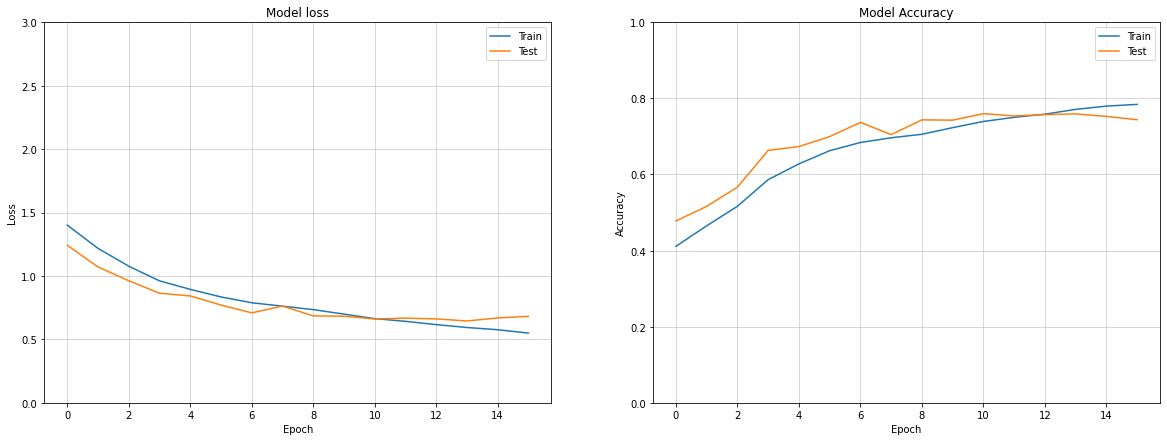

In [182]:
plot_loss_accuracy(history5, title=None)

In [183]:
model5.evaluate(X_test, y_test, verbose = 0)

[0.6513257622718811,
 0.7591394782066345,
 0.8351158499717712,
 0.6587457656860352]

In [170]:
predictions=model.predict(X_test)

In [171]:
y_test_1d=[np.argmax(y) for y in y_test]
predictions_1d=[np.argmax(y) for y in predictions]

In [172]:
dict={'y_test':y_test_1d,'predictions':predictions_1d}
df=pd.DataFrame.from_dict(dict)
df['results']=(df['y_test']==df['predictions'])
df

,y_test,predictions,results
0,1,2,False
1,0,2,False
2,1,1,True
3,0,0,True
4,3,3,True
...,...,...,...
7107,1,1,True
7108,0,0,True
7109,0,0,True
7110,0,0,True


In [173]:
df.groupby(['y_test']).mean()['results']

y_test
0    0.834476
1    0.804878
2    0.722278
3    0.539823
Name: results, dtype: float64

# Miroring image

In [222]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [217]:
np.array(data['pixels'][0]).reshape((48,48))

(48, 48)

In [215]:
np.reshape(data['pixels'][0].tolist(), (-1, 48, 48,1)).shape

(1, 48, 48, 1)

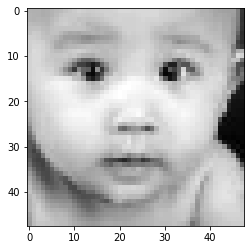

In [218]:
plt.imshow(np.array(data['pixels'][0]).reshape((48,48)),cmap='gray')

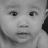

In [235]:
array=np.uint8(data['pixels'][0].reshape((48,48)))
img=Image.fromarray(array, 'L')
img

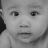

In [233]:
img_mirror=ImageOps.mirror(img)
img_mirror

In [234]:
img_mirror = img_mirror.getdata()
image_array = np.array(img_mirror, dtype=np.float32)
image_array

array([ 53.,  99., 118., ..., 142., 135., 115.], dtype=float32)

In [228]:
data['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [237]:
def pixel_mirroring(pixel):
    array=np.uint8(pixel.reshape((48,48)))
    img=Image.fromarray(array, 'L')
    img=ImageOps.mirror(img)
    img=img.getdata()
    pixel_mirror=np.array(img, dtype=np.float32)
    return pixel_mirror
        

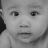

In [243]:
Image.fromarray(np.uint8(pixel_mirroring(data['pixels'][0]).reshape((48,48))), 'L')

In [244]:
hispanics=data[data['ethnicity']==4]

In [247]:
hispanics_mirrored=hispanics.copy()
hispanics_mirrored['pixels']=hispanics_mirrored['pixels'].apply(pixel_mirroring)
hispanics_mirrored.head()

,age,ethnicity,gender,img_name,pixels
161,1,4,0,20161221192604164.jpg.chip.jpg,"[180.0, 160.0, 56.0, 73.0, 76.0, 73.0, 80.0, 8..."
162,1,4,0,20161221192855037.jpg.chip.jpg,"[116.0, 120.0, 127.0, 137.0, 151.0, 158.0, 160..."
163,1,4,0,20161221193016140.jpg.chip.jpg,"[150.0, 87.0, 78.0, 83.0, 41.0, 12.0, 11.0, 20..."
164,1,4,0,20161221193041157.jpg.chip.jpg,"[186.0, 149.0, 73.0, 57.0, 67.0, 73.0, 67.0, 5..."
165,1,4,0,20161221193434166.jpg.chip.jpg,"[209.0, 210.0, 210.0, 207.0, 170.0, 56.0, 117...."


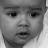

In [248]:
Image.fromarray(np.uint8(pixel_mirroring(hispanics_mirrored['pixels'][161]).reshape((48,48))), 'L')

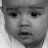

In [249]:
Image.fromarray(np.uint8(pixel_mirroring(hispanics['pixels'][161]).reshape((48,48))), 'L')